In [37]:
#Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import os
import json
import inspect
import collections
from datetime import datetime as dt
import time
import re
import ast


In [2]:
response = requests.get(url='https://store.steampowered.com/appreviews/413150?json=1').json()

In [3]:
#response

In [4]:
def get_reviews(appid, params={'json':1}):
        url = 'https://store.steampowered.com/appreviews/'
        response = requests.get(url=url+appid, params=params, headers={'User-Agent': 'Mozilla/5.0'})
        return response.json()


In [5]:
def get_n_reviews(appid, n=100):
    reviews = []
    cursor = '*'
    params = {
            'json' : 1,
            'filter' : 'all',
            'language' : 'english',
            'day_range' : 9223372036854775807,
            'review_type' : 'all',
            'purchase_type' : 'all'
            }

    while n > 0:
        params['cursor'] = cursor.encode()
        params['num_per_page'] = min(100, n)
        n -= 100

        response = get_reviews(appid, params)
        cursor = response['cursor']
        reviews += response['reviews']

        if len(response['reviews']) < 100: break

    return reviews

In [6]:
#def get_app_id(game_name):
#    response = requests.get(url=f'https://store.steampowered.com/search/?term={game_name}&category1=998', headers={'User-Agent': 'Mozilla/5.0'})
#    soup = BeautifulSoup(response.text, 'html.parser')
#    app_id = soup.find(class_='search_result_row')['data-ds-appid']
#    
#    return app_id

In [7]:
#To get a bunch of app IDs at once
def get_n_appids(n=100, filter_by='topsellers'):
    appids = []
    url = f'https://store.steampowered.com/search/?category1=998&filter={filter_by}&page='
    page = 0

    while page*25 < n:
        page += 1
        response = requests.get(url=url+str(page), headers={'User-Agent': 'Mozilla/5.0'})
        soup = BeautifulSoup(response.text, 'html.parser')
        for row in soup.find_all(class_='search_result_row'):
            appids.append(row['data-ds-appid'])

    return appids[:n]

In [8]:
#see how long it takes to execute this cell
start = time.time()

reviews = []
appids = get_n_appids(100) #100 app/"game" IDs, 100 top sellers?
for appid in appids:
    reviews += get_n_reviews(appid, 100)


end = time.time()

total_time = end - start
print("\n" + str(total_time))


40.215824127197266


In [9]:
#want to see how reviews looks like.
reviews

#first of all can look up who wrote the review/go to the actual review on Steam by looking up 'steamid'
#might be good to only look at reviews with substantial playtime_forever & playtime_last_two_weeks -> need to parse from "author"
#also 'votes_up' to see how many people found it helpful & votes_funny
#weighted_vote_score - might be good to pull it in to see how it varies

[{'recommendationid': '82020816',
  'author': {'steamid': '76561198110513339',
   'num_games_owned': 2696,
   'num_reviews': 7,
   'playtime_forever': 149262,
   'playtime_last_two_weeks': 39,
   'playtime_at_review': 146079,
   'last_played': 1675217310},
  'language': 'english',
  'review': "After 8 years playing it, I didn't improve my skills in-game.\n\nHowever, I learned new language skills: now I can curse in Russian and Brazilian Portuguese.\n\nAlso, my tolerance level to guttural screams and loud sounds was increased.\n\nNow I can bear the crying of my children for longer and I can make them feel better by singing sweet traditional songs from other cultures, such as –û—á–∏ —á—ë—Ä–Ω—ã–µ (Dark Eyes) or Garota de Ipanema (The Girl from Ipanema).\n\nIn conclusion, Counter Strike transformed me into a better father and a better person, in addition to making me more patient, tolerant to hateful people and more trained in languages and cultures.\n\nBetter than any psychiatric therapy.

In [10]:
df_init = pd.DataFrame(reviews)[['review','author','votes_up','votes_funny','weighted_vote_score', 'voted_up']]


In [11]:
df_init.shape

(9300, 6)

In [12]:
df_init.head()

review  \
0  After 8 years playing it, I didn't improve my ...   
1                                     I NOT CAN PLAY   
2  This community is so nice i got a lot of tips ...   
3  Your team in every random competitive game:\n\...   
4  The Best game on steam but it has the worst an...   

                                              author  votes_up  votes_funny  \
0  {'steamid': '76561198110513339', 'num_games_ow...      1614         1462   
1  {'steamid': '76561198058211132', 'num_games_ow...      2300          196   
2  {'steamid': '76561198158022300', 'num_games_ow...      1343          819   
3  {'steamid': '76561198388416030', 'num_games_ow...      1753          420   
4  {'steamid': '76561198815361023', 'num_games_ow...       500            3   

    weighted_vote_score  voted_up  
0  0.971687376499176025      True  
1  0.971291542053222656     False  
2  0.968922257423400879      True  
3  0.967435896396636963      True  
4  0.965640485286712646      True

In [13]:
#Need to parse out the data from the author field
pd.set_option('display.max_colwidth', None)
print(df_init['author'].head(1)) #example of what this author column looks like.

0    {'steamid': '76561198110513339', 'num_games_owned': 2696, 'num_reviews': 7, 'playtime_forever': 149262, 'playtime_last_two_weeks': 39, 'playtime_at_review': 146079, 'last_played': 1675217310}
Name: author, dtype: object


### Extracting more data from the author column

In [14]:
#Convert this column to list first
df_init['author'].head()

0    {'steamid': '76561198110513339', 'num_games_owned': 2696, 'num_reviews': 7, 'playtime_forever': 149262, 'playtime_last_two_weeks': 39, 'playtime_at_review': 146079, 'last_played': 1675217310}
1       {'steamid': '76561198058211132', 'num_games_owned': 384, 'num_reviews': 7, 'playtime_forever': 101658, 'playtime_last_two_weeks': 0, 'playtime_at_review': 87354, 'last_played': 1617129575}
2         {'steamid': '76561198158022300', 'num_games_owned': 255, 'num_reviews': 33, 'playtime_forever': 1254, 'playtime_last_two_weeks': 0, 'playtime_at_review': 1254, 'last_played': 1567873215}
3     {'steamid': '76561198388416030', 'num_games_owned': 1, 'num_reviews': 1, 'playtime_forever': 439081, 'playtime_last_two_weeks': 2823, 'playtime_at_review': 436409, 'last_played': 1675898910}
4        {'steamid': '76561198815361023', 'num_games_owned': 7, 'num_reviews': 6, 'playtime_forever': 204951, 'playtime_last_two_weeks': 0, 'playtime_at_review': 181968, 'last_played': 1641123812}
Name: author, d

In [15]:
author_fields = df_init['author'].values.tolist()

In [16]:
author_df = pd.DataFrame(author_fields, columns = ['steamid','num_games_owned','num_reviews','playtime_forever',
                                                   'playtime_last_two_weeks','playtime_at_review','last_played'])

In [17]:
author_df.shape

(9300, 7)

In [18]:
df = pd.concat([df_init, author_df], axis=1)

In [19]:
#df.head() #the author columns are included now

In [20]:
df.columns

Index(['review', 'author', 'votes_up', 'votes_funny', 'weighted_vote_score',
       'voted_up', 'steamid', 'num_games_owned', 'num_reviews',
       'playtime_forever', 'playtime_last_two_weeks', 'playtime_at_review',
       'last_played'],
      dtype='object')

In [21]:
#subset and rearrange columns
#won't really need "last_played"
df = df[['steamid','review','num_games_owned','num_reviews','playtime_forever','playtime_last_two_weeks','playtime_at_review',
         'votes_up','votes_funny','weighted_vote_score','voted_up']]

In [22]:
df.head()
#first review is weird.

steamid  \
0  76561198110513339   
1  76561198058211132   
2  76561198158022300   
3  76561198388416030   
4  76561198815361023   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           review  \
0  After 8 years playing it, I didn't improve my skills in-game.\n\nHowever, I learned new language skills: now I can curse in Russian and Brazilian Portuguese.\n\nAlso, my tolerance level to guttural screams and loud sounds was increased.\n\nNow I can bear the crying of my children for longer and I can make them feel better by singing sweet traditional songs from other cultures, such as –û—á–∏ —á—ë—Ä–Ω—ã–µ (Dark Eyes) or Garota de Ipanema (The Girl from Ipanema).\n\nIn conclusion, Counter Strike transformed me into a better father and a better person, in addition to making me more patient, tolerant to hateful people and more trained in languages and cultures.\n\nBetter than any psychiatric therapy. 10/10   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  I NOT CAN PLAY   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      This community is so nice i got a lot of tips on how to uninstall the game and kill myself   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Your team in every random competitive game:\n\n- You\n- Russian Guy\n- Another Russian Guy\n- A 6 year old kid who slept with your mother\n- Russian Guy who speaks English\n\n10/10   
4                                                                                                                                                                                                                                                                                                                         

In [23]:
#Proportion of reviews with thumbs up or down
df['voted_up'].value_counts()

True     7492
False    1808
Name: voted_up, dtype: int64

In [24]:
#examples of reviews that received a thumbs down
df[df['voted_up']==False]

steamid  \
1     76561198058211132   
9     76561198823299066   
63    76561198354594907   
66    76561198243124536   
81    76561198799665922   
...                 ...   
9163  76561198185114970   
9170  76561198013840418   
9172  76561198024614685   
9176  76561198331699122   
9184  76561198097850442   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

#### Import NLP libraries

In [25]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords

#### Next: lowercase, remove special characters/only keep letters, remove stop words, etc.

In [26]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

#Create a function that tries to clean the reviews
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower() #lowercase
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext) #remove weblinks
    rem_num = re.sub('[0-9]+', '', rem_url) #remove numbers
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')] #remove stop words
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)




In [27]:
#First row looks weird..try taking it out
df = df.iloc[1:]

In [28]:
df.head()

steamid  \
1  76561198058211132   
2  76561198158022300   
3  76561198388416030   
4  76561198815361023   
5  76561198036073172   

                                                                                                                                                                                 review  \
1                                                                                                                                                                        I NOT CAN PLAY   
2                                                                                            This community is so nice i got a lot of tips on how to uninstall the game and kill myself   
3  Your team in every random competitive game:\n\n- You\n- Russian Guy\n- Another Russian Guy\n- A 6 year old kid who slept with your mother\n- Russian Guy who speaks English\n\n10/10   
4                                                                                                                                The Best game on steam but it has the worst anticheat.   
5                                                                                            This community is so nice i got a lot of tips on how to uninstall the game and kill myself   

   num_games_owned  num_reviews  playtime_forever  playtime_last_two_weeks  \
1              384            7            101658                        0   
2              255           33              1254                        0   
3                1            1            439081                     2823   
4                7            6            204951                        0   
5              321            5              9827                      248   

   playtime_at_review  votes_up  votes_funny   weighted_vote_score  voted_up  
1               87354      2300          196  0.971291542053222656     False  
2                1254      1343          819  0.968922257423400879      True  
3              436409      1753          420  0.967435896396636963      True  
4              181968       500            3  0.965640485286712646      True  
5                8458       989          660  0.965431809425354004      True

#### Apply the preprocess function

In [29]:
start = time.time()

df['clean_review']=df['review'].map(lambda s:preprocess(s))

end = time.time()

total_time = end - start
print("\n" + str(total_time))

In [30]:
#df.head()

In [31]:
#df['steamid'].nunique()

In [32]:
#Again, reorder and subset columns
df = df[['clean_review','num_games_owned','num_reviews','playtime_forever','playtime_last_two_weeks','playtime_at_review',
         'votes_up','votes_funny','weighted_vote_score','voted_up']]

In [33]:
df.head()

clean_review  \
1                                                                                                                     play   
2                                                                          community nice got lot tips uninstall game kill   
3  team every random competitive game russian guy another russian guy year old kid slept mother russian guy speaks english   
4                                                                                          best game steam worst anticheat   
5                                                                          community nice got lot tips uninstall game kill   

   num_games_owned  num_reviews  playtime_forever  playtime_last_two_weeks  \
1              384            7            101658                        0   
2              255           33              1254                        0   
3                1            1            439081                     2823   
4                7            6            204951                        0   
5              321            5              9827                      248   

   playtime_at_review  votes_up  votes_funny   weighted_vote_score  voted_up  
1               87354      2300          196  0.971291542053222656     False  
2                1254      1343          819  0.968922257423400879      True  
3              436409      1753          420  0.967435896396636963      True  
4              181968       500            3  0.965640485286712646      True  
5                8458       989          660  0.965431809425354004      True

In [81]:
df[df['voted_up']==False]

clean_review  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [34]:
#No nulls
df.isna().sum()

clean_review               0
num_games_owned            0
num_reviews                0
playtime_forever           0
playtime_last_two_weeks    0
playtime_at_review         0
votes_up                   0
votes_funny                0
weighted_vote_score        0
voted_up                   0
dtype: int64

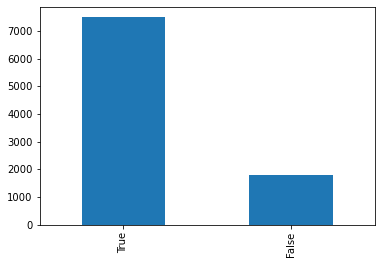

In [49]:
#Compare target class
df['voted_up'].value_counts().plot(kind='bar')

In [75]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [65]:
df_pos = df[df['voted_up']==True]

In [74]:
df_pos.shape

(7491, 10)

In [71]:
df_neg = df[df['voted_up']==False]

In [72]:
df_neg.shape

(1808, 10)

In [76]:
wc = WordCloud(stopwords = stop_words, collocations = False, max_font_size=55, max_words=25, background_color='white')

(-0.5, 399.5, 199.5, -0.5)

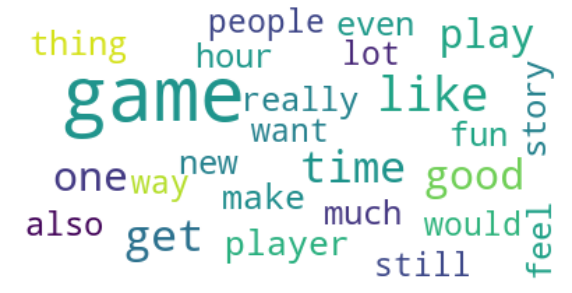

In [79]:
wc.generate(' '.join(df_pos['clean_review']))
plt.figure(figsize=(10,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off") #Voted Up Reviews WordCloud

(-0.5, 399.5, 199.5, -0.5)

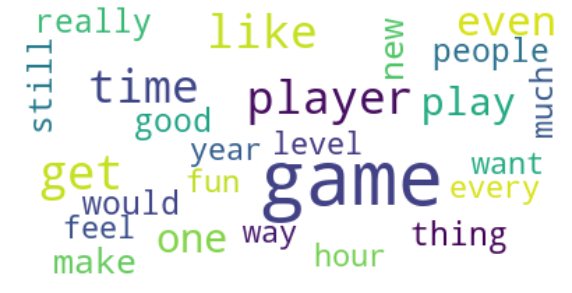

In [80]:
wc.generate(' '.join(df_neg['clean_review']))
plt.figure(figsize=(10,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off") #Voted Down Reviews Wordcloud

In [ ]:
show_wordcloud(Samsung_Reviews_Negative['Reviews'])


In [ ]:
show_wordcloud(Samsung_Reviews_positive['Reviews'])

In [35]:
#Change Target Column to Binary


False  True
1         1     0
2         0     1
3         0     1
4         0     1
5         0     1
...     ...   ...
9295      0     1
9296      0     1
9297      0     1
9298      0     1
9299      0     1

[9299 rows x 2 columns]

#### Split data into training and test set

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_df.OriginalTweet.values, train_df.Sentiment.values,
                                                  stratify=train_df.Sentiment.values,
                                                  test_size=.1, shuffle=True, random_state=42)



In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape